# Foundations of Deep Learning - Project

*Marco Donzella 829358, Rebecca Picarelli 834286*

## 1. The dataset

Il dataset scelto per le analisi è CIFAR-10, scaricabile al seguente link: https://www.cs.toronto.edu/~kriz/cifar-10-matlab.tar.gz

Per effettuare dei test, è possibile utilizzare la versione di tale dataset presente su tensorflow.

*N.B.: assicurarsi di aver cambiato il tipo di runtime da CPU a GPU!*

In [ ]:
# Runtime -> change runtime type -> GPU
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from skimage import io # Input/output
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

Come prima fase, si decide di utilizzare il dataset disponibile su keras:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
print('Le dimensioni del dataset di training sono: '+str(x_train.shape))
print('Le dimensioni del target di training sono: '+str(y_train.shape))
print('Le dimensioni del dataset di test sono: '+str(x_test.shape))
print('Le dimensioni del target di training sono: '+str(y_test.shape))

Le dimensioni del dataset di training sono: (50000, 32, 32, 3)
Le dimensioni del target di training sono: (50000, 1)
Le dimensioni del dataset di test sono: (10000, 32, 32, 3)
Le dimensioni del target di training sono: (10000, 1)


Dalle dimensioni si evince che le immagini sono a colori, in quanto caratterizzate da tre canali (RGB).

Viene riportato un record di esempio:

In [ ]:
index = 0 # choose the index

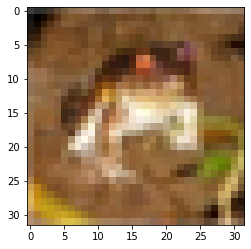

In [ ]:
plt.imshow(x_train[index]);

Il primo record del dataset di training sembrerebbe essere una rana e, come affermato prima, l'immagine è a colori.

Viene riportato anche il target di tale record:

In [ ]:
y_train[index]

array([6], dtype=uint8)

É possibile ottenere la label di classificazione creando una lista (https://www.cs.toronto.edu/~kriz/cifar.html):

In [ ]:
# Da array a classe
classification = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("The image class is:", classification[y_train[index][0]])

The image class is: frog


In questo modo è possibile visualizzare alcuni record ed il relativo target.

## 2. Preprocessing

Prima di poter dare i dati in input ad una rete neurale, è necessario normalizzarli e trasformare il target con la codifica *one-hot encoding*.

É stata anche eseguita una fase di data augmentation per modificare le immagini in input e costruire un modello che riesca ad adattarsi meglio a nuovi dati.

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    
    )
datagen.fit(x_train)

In [ ]:
#Riformattare le immagini
img_rows, img_cols , channels= 32,32,3
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
 x_train = x_train.astype('float32')/255.0 
 x_test = x_test.astype('float32')/255.0

Inoltre, è possibile effettuare anche la standardizzazione dei dati dopo averli normalizzati

In [ ]:
# Standardizzazione per ogni canale  (si poterbbe effettuare anche con valori globali di media e std)

x_train_local_mean = np.mean(x_train.astype(np.float32), axis=(0,1,2))
x_train_local_std = np.std(x_train.astype(np.float32), axis=(0,1,2))
x_train = (x_train.astype(np.float32) - x_train_local_mean) / x_train_local_std
x_test = (x_test.astype(np.float32) - x_train_local_mean) / x_train_local_std

In [ ]:
yc_train = keras.utils.to_categorical(y_train, 10) 
yc_test = keras.utils.to_categorical(y_test, 10)

## 3. Modello per la classificazione delle immagini

Viene ora costruita una rete neurale che riesca a classificare correttamente l'immagine che gli verrà passata come input.

In [ ]:
# Si definisce la funzione di attivazione Mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

In [ ]:
#weights=0.05 0.01 0.005 0.1
model = Sequential()
model.add(keras.Input((32,32,3)))
model.add(Conv2D(32, (3, 3), activation='Mish', padding='same', kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)))  
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='Mish', padding='same',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='Mish', padding='same',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='Mish', padding='same',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='Mish',  padding='same',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='Mish',kernel_initializer='he_uniform') )
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
# Definire l'early stopping
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
callbacks=keras.callbacks.EarlyStopping(monitor='accuracy', patience=10) 

In [ ]:
#Altre opzioni scartate per l'ottimizzazione
#opt = SGD(lr=0.001, momentum=0.9)
#opt_adam = keras.optimizers.Adam( beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-8)
#opt_rms = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer = 'Adam', 
              metrics = ['accuracy'])  # adamax, adadelta

In [ ]:
history = model.fit(x_train, yc_train, batch_size=128, steps_per_epoch=x_train.shape[0]//128,epochs=100, verbose=1, 
          validation_data=(x_test, yc_test),
          callbacks=[callbacks])

Epoch 1/100
390/390 [==============================] - 22s 23ms/step - loss: 2.3811 - accuracy: 0.4054 - val_loss: 1.9134 - val_accuracy: 0.5195
Epoch 2/100
390/390 [==============================] - 8s 21ms/step - loss: 1.6959 - accuracy: 0.5807 - val_loss: 1.4981 - val_accuracy: 0.6340
Epoch 3/100
390/390 [==============================] - 8s 21ms/step - loss: 1.4194 - accuracy: 0.6483 - val_loss: 1.2830 - val_accuracy: 0.6815
Epoch 4/100
390/390 [==============================] - 8s 21ms/step - loss: 1.2257 - accuracy: 0.6890 - val_loss: 1.0851 - val_accuracy: 0.7341
Epoch 5/100
390/390 [==============================] - 8s 21ms/step - loss: 1.1028 - accuracy: 0.7173 - val_loss: 1.0561 - val_accuracy: 0.7213
Epoch 6/100
390/390 [==============================] - 8s 22ms/step - loss: 1.0142 - accuracy: 0.7369 - val_loss: 0.9941 - val_accuracy: 0.7350
Epoch 7/100
390/390 [==============================] - 9s 22ms/step - loss: 0.9479 - accuracy: 0.7522 - val_loss: 0.9150 - val_accuracy

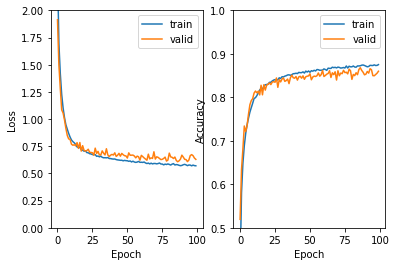

In [ ]:
# Grafico delle learning curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
# Evaluation
score = model.evaluate(x_test, yc_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6294028759002686
Test accuracy: 0.8600000143051147


In [ ]:
# Esempio di un risultato ottenuto precedentemente
#score = model.evaluate(x_test, yc_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

Test loss: 0.6209320425987244
Test accuracy: 0.8622000217437744


In [ ]:
# Inferenza
yc_pred = model.predict(x_test)
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1000
           1       0.92      0.95      0.93      1000
           2       0.83      0.78      0.80      1000
           3       0.78      0.71      0.74      1000
           4       0.84      0.85      0.84      1000
           5       0.87      0.74      0.80      1000
           6       0.80      0.95      0.87      1000
           7       0.90      0.89      0.89      1000
           8       0.91      0.93      0.92      1000
           9       0.93      0.90      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion matrix:
[[904  10  11   3   7   0   9   4  44   8]
 [  4 950   0   1   1   1   3   0   9  31]
 [ 59   0 778  19  41  21  61  10   9   2]
 [ 21   6  49 707  41  63  74  18  10  11]
 [ 13   1  30  21 848   6  4

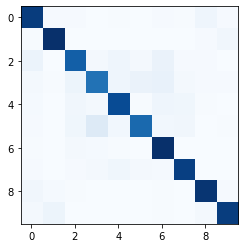

In [ ]:
# Classification report e confusion matrix
print('Classification report:')
print(classification_report(y_test, y_pred))

print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Struttura della rete neurale

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

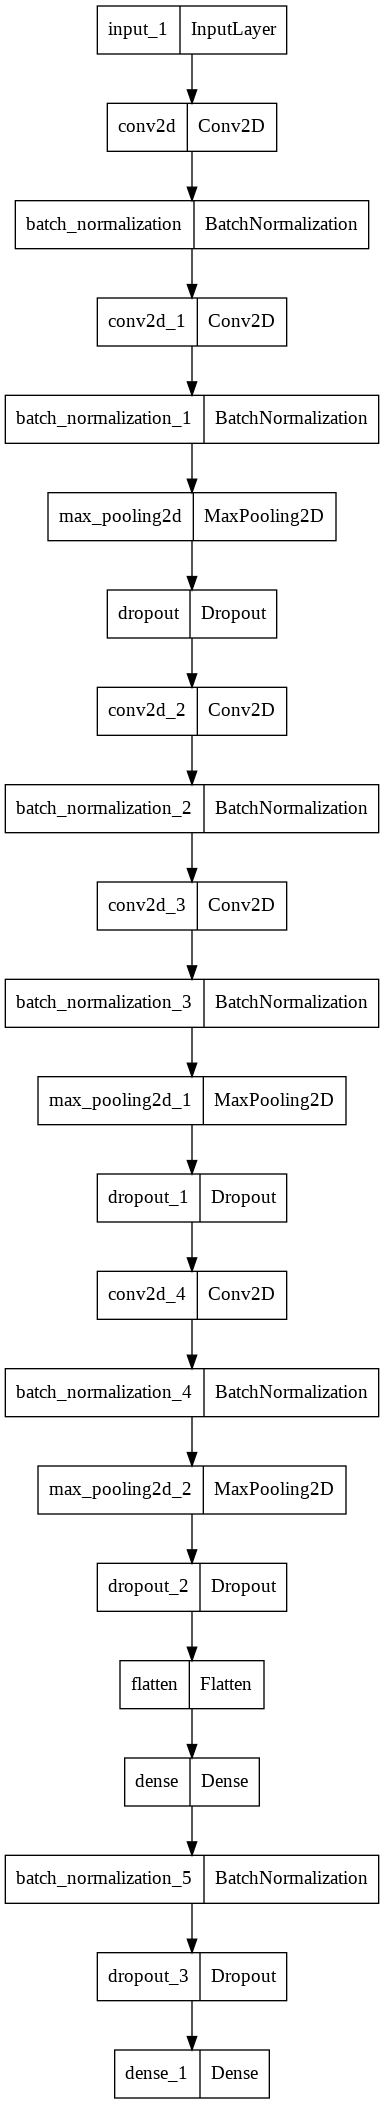

In [ ]:
keras.utils.plot_model(model)

## 5. Salvataggio della versione migliore del modello, con successivo caricamento e controllo dello score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Per caricare il modello preaddestrato:

In [ ]:
#model.save('./drive/My Drive/FoDL_project/cnn_model')

In [ ]:
from keras.models import load_model
# Caricamento del modello
net_model = load_model('./drive/My Drive/Foundations od Deep Learning/FDL_Project/cnn_model')

In [ ]:
# Evaluation del modello salvato
score_saved_model = net_model.evaluate(x_test, yc_test, verbose=0)
print('Test loss:', score_saved_model[0])
print('Test accuracy:', score_saved_model[1])

Test loss: 0.6139525175094604
Test accuracy: 0.8651999831199646
